# Notebook Setup
Installs necessary requirements and configures proper notebook behavior  
Note: The notebook assumes you are using the base conda environment

In [3]:
%load_ext autoreload
%autoreload 2
# !python -m pip install -r requirements.txt
    
print("Notebook setup has completed")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Notebook setup has completed


# Download Data
Specify which datasets to use and download

In [4]:
CDS_AND_VINYL_JSON_PARAMS = {
    'file': 'CDs_and_Vinyl_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
CELL_PHONE_JSON_PARAMS = {
    'file': 'Cell_Phones_and_Accessories_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
CLOTHING_JSON_PARAMS = {
    'file': 'Clothing_Shoes_and_Jewelry_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
ELECTRONICS_JSON_PARAMS = {
    'file': 'Electronics_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
HOME_AND_KITCHEN_JSON_PARAMS = {
    'file': 'Home_and_Kitchen_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
KINDLE_STORE_JSON_PARAMS = {
    'file': 'Kindle_Store_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
MOVIES_JSON_PARAMS = {
    'file': 'Movies_and_TV_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}
SPORTS_JSON_PARAMS = {
    'file': 'Sports_and_Outdoors_5.json.gz',
    'filetype': 'json',
    'features': "reviewText",
    'labels': "overall",
}

In [6]:
from bootstrap import download_data_file
DATASETS = [ CDS_AND_VINYL_JSON_PARAMS, CELL_PHONE_JSON_PARAMS , KINDLE_STORE_JSON_PARAMS, SPORTS_JSON_PARAMS ]
URL_SOURCE = "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/"

for dataset in DATASETS:
    download_data_file(URL_SOURCE, dataset['file'])
    

File /home/elizabeth/dev/ML-Project/data/CDs_and_Vinyl_5.json.gz already exists, skipping download
File /home/elizabeth/dev/ML-Project/data/Cell_Phones_and_Accessories_5.json.gz already exists, skipping download
File /home/elizabeth/dev/ML-Project/data/Kindle_Store_5.json.gz already exists, skipping download
File /home/elizabeth/dev/ML-Project/data/Sports_and_Outdoors_5.json.gz already exists, skipping download


In [7]:
from preprocessing import get_dataframe_file
import pandas as pd
POINTS_PER_FILE = 50_000
frames = []
for file in DATASETS:
    frame = get_dataframe_file(params = file, equalize=True)
    frame.dropna(inplace=True)
    frames.append(frame)

In [8]:
df = pd.concat(frames)
df.head()

,reviewText,overall
90,I just don't understand how someone could reco...,1
117,With all due respect to all you people who lov...,1
219,"This CD seems too ""disjointed""---it does not f...",1
256,This is another Sharon Osborne rip-off . Just ...,1
257,"After DIO Sabbath with ozzy singing is crap, h...",1


# Format Data
Split into training, testing, and validation sets, and transform text into a format that can be used by the model

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import get_subsets

word_vectorizer = CountVectorizer(
    min_df=0.0001, 
    max_df=0.7
 )
X = df["reviewText"].to_numpy()
X = word_vectorizer.fit_transform(X)
df['overall'].replace(2, 1, inplace=True)
df['overall'].replace(4, 5, inplace=True)
y = df['overall'].to_numpy()

X_train, X_val, X_test, y_train, y_val, y_test = get_subsets(X,y, train_split=0.8, val_split=0.1, test_split=0.1)
print(f"X_train: {X_train.shape}\t y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\t y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\t y_test: {y_test.shape}")


X_train: (1001527, 16527)	 y_train: (1001527,)
X_val: (125191, 16527)	 y_val: (125191,)
X_test: (125191, 16527)	 y_test: (125191,)


# Visualize Data Distribution

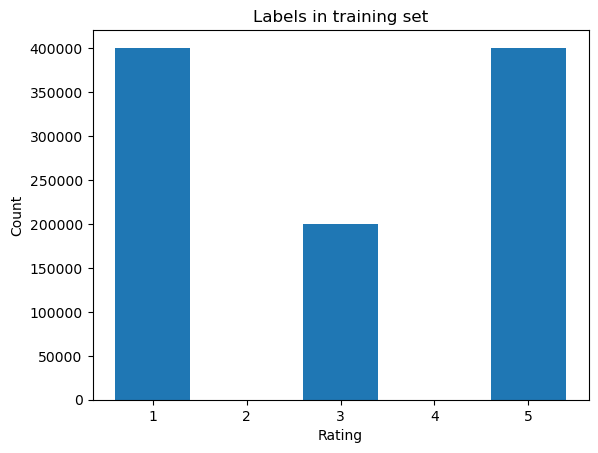

Label mean:  2.999372957493907
Label Standard Deviation:  1.7887073571171297


In [10]:
import matplotlib.pyplot as plt
import numpy as np
categories, counts = np.unique(y_train, return_counts=True)
plt.bar(categories, counts)
plt.title("Labels in training set")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()
print("Label mean: ", np.mean(y_train))
print("Label Standard Deviation: ", np.std(y_train))

# Training the Model

In [11]:
from mlp import MultiLayerPerceptron
our_mlp = MultiLayerPerceptron(
    epochs=20,
    lr=0.2,
    hidden_layers=[50, 20],
    activation="logistic",
    regularization="L2",
    reg_const=0.0001,
)
our_mlp.fit(X_train, y_train, X_val, y_val, batch_size=200)

100%|██████████| 20/20 [07:04<00:00, 21.23s/it]


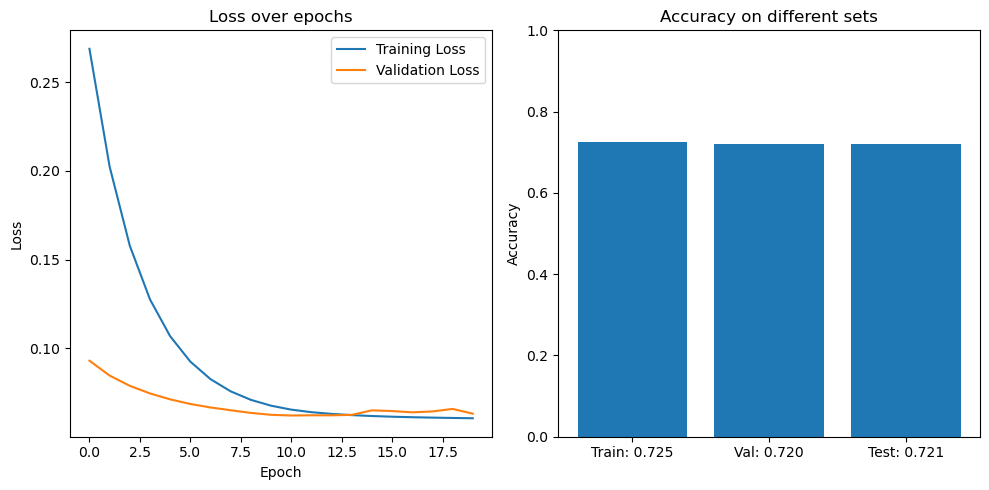

In [12]:
training_score = our_mlp.score(X_train, y_train)
validation_score = our_mlp.score(X_val, y_val)
test_score = our_mlp.score(X_test, y_test)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(our_mlp.train_loss_curve, label="Training Loss")
ax1.plot(our_mlp.val_loss_curve, label="Validation Loss")
ax1.set_title("Loss over epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.bar([f"Train: {training_score:.3f}", f"Val: {validation_score:.3f}", f"Test: {test_score:.3f}"], 
    [training_score, validation_score, test_score])
ax2.set_title("Accuracy on different sets")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

fig.tight_layout()

In [13]:
from sklearn.metrics import classification_report

y_pred = our_mlp.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           1       0.68      0.92      0.78     50182
           3       0.52      0.22      0.31     25041
           5       0.83      0.77      0.80     49968

    accuracy                           0.72    125191
   macro avg       0.68      0.64      0.63    125191
weighted avg       0.71      0.72      0.69    125191



# Benchmarking

In [14]:
from sklearn.neural_network import MLPClassifier
sklearn_mlp = MLPClassifier(
    early_stopping=True,
)
sklearn_mlp = sklearn_mlp.fit(X_train, y_train)

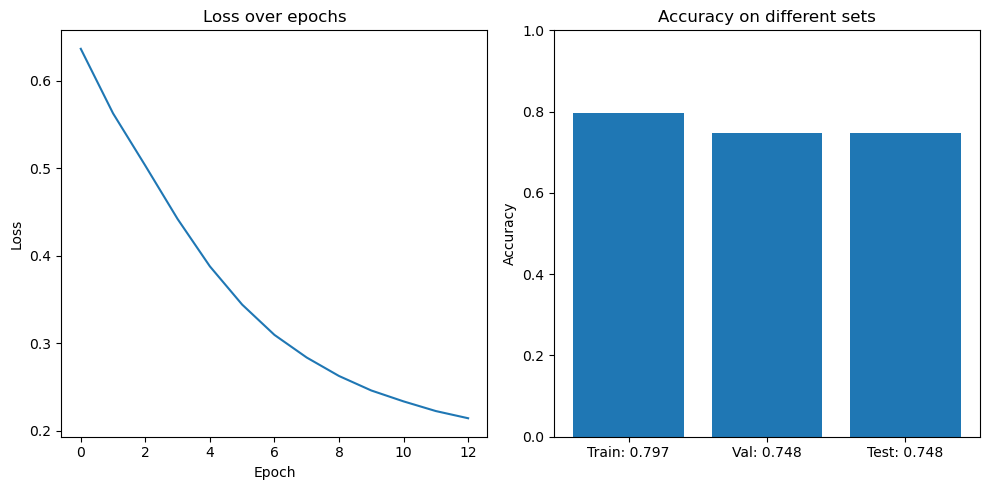

In [15]:
training_score = sklearn_mlp.score(X_train, y_train)
validation_score = sklearn_mlp.score(X_val, y_val)
test_score = sklearn_mlp.score(X_test, y_test)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(sklearn_mlp.loss_curve_)
ax1.set_title("Loss over epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.bar([f"Train: {training_score:.3f}", f"Val: {validation_score:.3f}", f"Test: {test_score:.3f}"], 
    [training_score, validation_score, test_score])
ax2.set_title("Accuracy on different sets")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1)

fig.tight_layout()

In [16]:
from sklearn.metrics import classification_report

y_pred = sklearn_mlp.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           1       0.76      0.86      0.81     50182
           3       0.53      0.29      0.38     25041
           5       0.79      0.86      0.82     49968

    accuracy                           0.75    125191
   macro avg       0.69      0.67      0.67    125191
weighted avg       0.73      0.75      0.73    125191



In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [ ]:
training_score = clf.score(X_train, y_train)
validation_score = clf.score(X_val, y_val)
test_score = clf.score(X_test, y_test)
plt.bar([f"Train: {training_score:.3f}", f"Val: {validation_score:.3f}", f"Test: {test_score:.3f}"], 
    [training_score, validation_score, test_score])
plt.title("Accuracy on different sets")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

## Tensorflow Benchmarking
If you are not using a GPU, this might take a while

In [ ]:
#Free GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
import tensorflow as tf

# clear tensoflow backend
tf.keras.backend.clear_session()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax"),
    tf.keras.layers.Dense(1, activation="linear"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["accuracy", "mse", "mae"]
)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
keras_X_train = X_train.toarray()
keras_X_val = X_val.toarray()
keras_y_train = y_train - 1
keras_y_val = y_val - 1
model.fit(keras_X_train, keras_y_train, epochs=10, validation_data=(keras_X_val, keras_y_val), callbacks=[callback])

# Training

In [ ]:
from sympy import Lambda, Symbol
from training import matrix_train


x = Symbol("x")


# each axis must be an iterable. if you want to use a constant, wrap it in an iterable of len 1
hyperparameter_matrix = {
    "epochs": np.logspace(np.log10(100), np.log10(100000), num=20, dtype="int64"),
    "lr": np.logspace(np.log10(.00001), np.log10(.1), num=20),
    "hidden_layers": [5, 6, 7],
    "neurons_per_layer": [3],
    "activation": [Lambda(x, x**2)],
}

best_params = matrix_train(hyperparameter_matrix, MultiLayerPerceptron, X_train, y_train, X_test, y_test)

print(best_params)
# mlp = MultiLayerPerceptron(**best_params)


# Performance

In [ ]:
from analysis import accuracy, confusion, report


mlp = MultiLayerPerceptron(**best_params)
mlp.fit(X_train, y_train)

# print(accuracy(mlp.predict(X_test), y_test))
# print(confusion(mlp.predict(X_test), y_test))
print(report(mlp.predict(X_test), y_test))


# Benchmarking

In [ ]:
# TODO utilize other classifiers and compare performance